https://zhuanlan.zhihu.com/p/40226021

In [1]:
import gym
import math
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [4]:
class Agent(object):
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.eval_net = Net(self.state_space_dim, 256, self.action_space_dim)
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=self.lr)
        self.buffer = []
        self.steps = 0
        
    def act(self, s0):
        self.steps += 1
        epsi = self.epsi_low + (self.epsi_high-self.epsi_low) * (math.exp(-1.0 * self.steps/self.decay))
        if random.random() < epsi:
            a0 = random.randrange(self.action_space_dim)
        else:
            s0 =  torch.tensor(s0, dtype=torch.float).view(1,-1)
            a0 = torch.argmax(self.eval_net(s0)).item()
        return a0

    def put(self, *transition):
        if len( self.buffer)==self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)
        
    def learn(self):
        if (len(self.buffer)) < self.batch_size:
            return
        
        samples = random.sample( self.buffer, self.batch_size)
        s0, a0, r1, s1 = zip(*samples)
        s0 = torch.tensor( s0, dtype=torch.float)
        a0 = torch.tensor( a0, dtype=torch.long).view(self.batch_size, -1)
        r1 = torch.tensor( r1, dtype=torch.float).view(self.batch_size, -1)
        s1 = torch.tensor( s1, dtype=torch.float)
        
        y_true = r1 + self.gamma * torch.max( self.eval_net(s1).detach(), dim=1)[0].view(self.batch_size, -1)
        y_pred = self.eval_net(s0).gather(1, a0)
        
        loss_fn = nn.MSELoss()
        loss = loss_fn(y_pred, y_true)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
from IPython import display
import matplotlib.pyplot as plt

In [6]:
def plot(score, mean):
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(20,10))
    plt.clf()

    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(score)
    plt.plot(mean)
    plt.text(len(score)-1, score[-1], str(score[-1]))
    plt.text(len(mean)-1, mean[-1], str(mean[-1]))

In [7]:
env = gym.make('CartPole-v0')

In [8]:
    params = {
        'gamma': 0.8,
        'epsi_high': 0.9,
        'epsi_low': 0.05,
        'decay': 200, 
        'lr': 0.001,
        'capacity': 10000,
        'batch_size': 64,
        'state_space_dim': env.observation_space.shape[0],
        'action_space_dim': env.action_space.n   
    }
    agent = Agent(**params)

In [9]:
    score = []
    mean = []

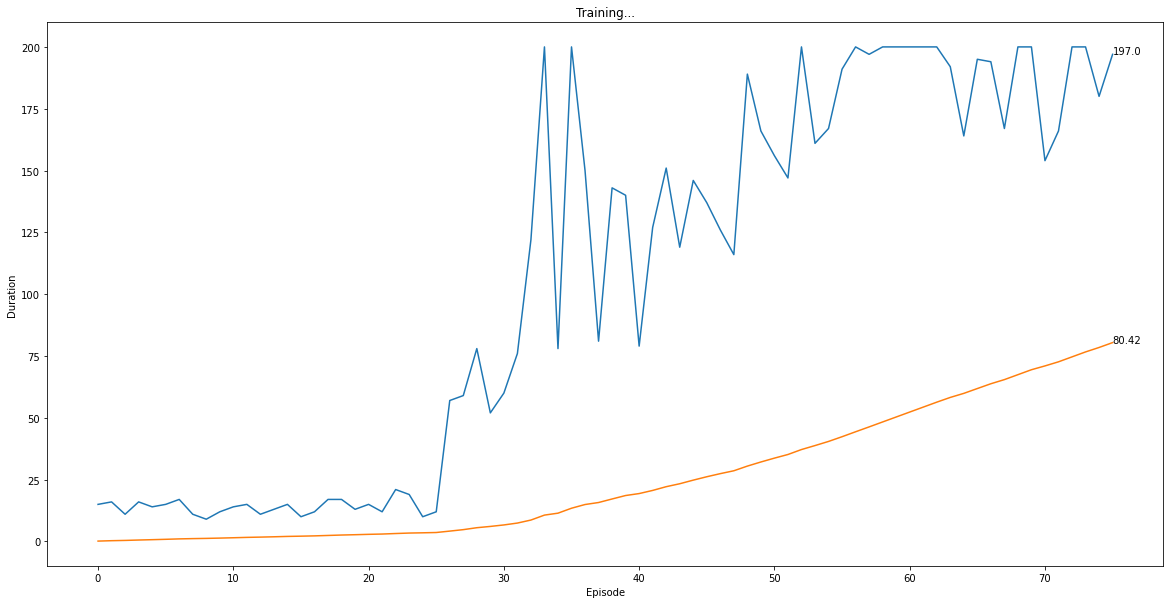

KeyboardInterrupt: 

In [10]:
    for episode in range(1000):
        s0 = env.reset()
        total_reward = 1
        while True:
            env.render()
            a0 = agent.act(s0)
            s1, r1, done, _ = env.step(a0)
            
            if done:
                r1 = -1
                
            agent.put(s0, a0, r1, s1)
            
            if done:
                break

            total_reward += r1
            s0 = s1
            agent.learn()
        score.append(total_reward)
        mean.append( sum(score[-100:])/100)

        plot(score, mean)